# CSE 622 Final Project
Spring 2023  
E Tracy

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygame as pg
from scipy import signal
import pandas as pd

pygame 2.3.0 (SDL 2.24.2, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Setting up the ruleset

In [2]:
# Class for holding number values corresponding to distinct cell states
class States:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Social Dynamics

In [84]:
class SocialDynamics:
    def __init__(self, screen, target_fps, room_size, draw=True, max_gen=np.inf, seed=None):
        self.screen = screen
        self.target_fps = target_fps
        self.max_gen = max_gen
        self.draw = draw
        self.clock = pg.time.Clock()
        # self.w = self.screen.get_size()[0]
        # self.h = self.screen.get_size()[1]
        self.w  = room_size[0]
        self.h = room_size[1]
        self.room_window = pg.Surface(room_size)
        self.states = States(
            dead = 0,
            neutral = 1,
            unhappy = 2,
            happy = 3
        )
        self.bgc = (0, 0, 0)
        self.colors = [0]*len(self.states.__dict__)
        self.colors[self.states.dead] = (0, 0, 0)
        self.colors[self.states.neutral] = (0, 0, 255)
        self.colors[self.states.unhappy] = (255, 0, 0)
        self.colors[self.states.happy] = (0, 255, 0)
        # used for randomly setting cell states at t=0
        self.p_neutral = 0.1
        self.p_happy = 0.1
        self.p_unhappy = 0.1
        self.p_dead = 1-(self.p_happy+self.p_neutral+self.p_unhappy)
        # may need to specify seed here
        self.rand = np.random.default_rng(seed=seed)
        self.generation = 0
        self.n_cells_changed = 0
        self.n_cells_alive = 0
        # used for helper functions to find neighbors
        self.nbmask = np.array([[1,1,1],[1,0,1],[1,1,1]]) # moore neighborhood
        # self.nbmask = np.array([[0,1,0],[1,0,1],[0,1,0]]) # neumann neighborhood
        self.popdata = pd.DataFrame(columns=['generation','happy','unhappy','neutral','alive','change'])
        self.popdata.sort_index(inplace=True)
        self.max_history = 10
        # self.birth_probs = [0.21495]*3 # interesting stability here
        self.birth_probs = self.rand.uniform(0.1,0.3, size=3).tolist()
        self.birth_probs.insert(0,1-sum(self.birth_probs))
        self.paused = False
        self.setup_room()
    
    def run(self):
        self.running = True
        step_once = False
        state_selected = 0
        while self.running:
            # handle events
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    self.running = False
                elif event.type == pg.KEYDOWN:
                    if event.key == pg.K_ESCAPE:
                        self.running = False
                    if event.key == pg.K_SPACE:
                        self.paused = not self.paused
                    if event.key == pg.K_n:
                        step_once = True
                elif event.type == pg.MOUSEBUTTONDOWN:
                    if event.button == pg.BUTTON_LEFT:
                        x,y = pg.mouse.get_pos()
                        x = int(self.w * x / self.screen.get_rect().size[0])
                        y = int(self.h * y / self.screen.get_rect().size[1])
                        self.room[x+1,y+1] = state_selected
                    elif event.button == pg.BUTTON_RIGHT:
                        state_selected = state_selected + 1 if state_selected < 3 else 0
                        print("selected state:",["dead","neutral","unhappy","happy"][state_selected])
                elif event.type == pg.MOUSEMOTION:
                    x,y = pg.mouse.get_pos()
                    mx = int(self.w * x / self.screen.get_rect().size[0])
                    my = int(self.h * y / self.screen.get_rect().size[1])                    
            
            # handle game logic here
            self.plot_life()            
            # update cursor
            while self.screen.get_locked():
                self.screen.unlock()
            if self.draw:
                if 'mx' in locals() and 'my' in locals():
                    rgbarr = pg.surfarray.pixels2d(self.room_window)
                    rgbarr[mx,my] = self.get_24bit_color(self.colors[state_selected])
                    self.screen.blit(pg.transform.scale(self.room_window, self.screen.get_rect().size), (0,0))
            if self.paused:
                if step_once:
                    step_once = False
                    self.new_generation()
                pg.time.wait(10)
            else:
                self.new_generation()
            
            if self.draw:            
                # screen locks
                while self.screen.get_locked():
                    self.screen.unlock()

                # update the screen
                pg.display.flip()
                # limit the fps
                self.clock.tick(self.target_fps)
    
    # counts happy neigbhors around cell (i,j) inside of arr
    def _count_happy_neighbors(self, arr, i,j):
        sub_array = arr[i-1:i+2, j-1:j+2]
        return np.sum(sub_array[self.nbmask]==self.states.happy)
    # counts unhappy neigbhors around cell (i,j) inside of arr
    def _count_unhappy_neighbors(self, arr, i,j):
        sub_array = arr[i-1:i+2, j-1:j+2]
        return np.sum(sub_array[self.nbmask]==self.states.unhappy)
    # counts neutral neigbhors around cell (i,j) inside of arr
    def _count_neutral_neighbors(self, arr, i,j):
        sub_array = arr[i-1:i+2, j-1:j+2]
        return np.sum(sub_array[self.nbmask]==self.states.neutral)
    # counts neigbhors around cell (i,j) inside of arr
    def _count_neighbors(self, arr, i,j):
        sub_array = arr[i-1:i+2, j-1:j+2]
        return np.sum(sub_array[self.nbmask]!=self.states.dead)
    
    def _generate_rule_texture(self):
        import itertools
        self.ruletex = pd.DataFrame(columns=['N0-dead','N1-neutral', 'N2-unhappy', 'N3-happy'])
        self.ruletex.sort_index(inplace=True)
        permutations = itertools.product(range(9), repeat=4)
        sum_eight = filter(lambda x: sum(x) == 8, permutations)
        for row in sum_eight:
            self.ruletex.loc[len(self.ruletex.index)] = list(row)
        rows_for_one_state = len(self.ruletex.index)
        self.ruletex = pd.concat(4*[self.ruletex])
        self.ruletex.reset_index(inplace=True)
        self.ruletex.drop(columns='index', inplace=True)
        for state in range(4):
            # self.ruletex.loc[state*rows_for_one_state:(state+1)*rows_for_one_state, 'current_state'] = state
            self.ruletex.loc[state*rows_for_one_state:(state+1)*rows_for_one_state - 1, 'current_state'] = state
        self.ruletex['current_state']=self.ruletex['current_state'].astype(np.uint8)
        

    def new_generation(self):
        # create a new generation using the ruleset
        check_frequency = 5 # every n generations do a life check
        self.generation += 1
        w,h = self.w,self.h

        self.record_history()
        
        happy_neighbors = signal.convolve2d(self.room==self.states.happy, self.nbmask, mode='same')[1:w+1, 1:h+1]
        unhappy_neighbors = signal.convolve2d(self.room==self.states.unhappy, self.nbmask, mode='same')[1:w+1, 1:h+1]
        # neutral_neighbors = signal.convolve2d(self.room==self.states.neutral, self.nbmask, mode='same')[1:w+1, 1:h+1]
        neighbor_count = signal.convolve2d(self.room>0, self.nbmask, mode='same')[1:w+1, 1:h+1]
        
        new_room = np.zeros_like(self.room)
        # maze world
        # new_room = self.room.copy()
        
        
        # rule 1
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.happy)\
                                &(unhappy_neighbors[:,:]>0)] = self.states.unhappy 
        # rule 2
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.happy)\
                                &(neighbor_count[:,:]==2)] = self.states.neutral
        # rule 3
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.unhappy)\
                                &(happy_neighbors[:,:]>0)] = self.states.happy
        # rule 4
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.unhappy)\
                                &(neighbor_count[:,:]==2)] = self.states.neutral
        # rule 5
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
                                &(happy_neighbors[:,:]>unhappy_neighbors[:,:])] = self.states.happy
        # rule 6
        new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
                                &(happy_neighbors[:,:]<unhappy_neighbors[:,:])] = self.states.unhappy
        
        # new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
        #                         &(happy_neighbors[:,:]==unhappy_neighbors[:,:])] = self.states.neutral
        
        # rule 4a
        # new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.dead)\
        #                         &(neighbor_count[:,:]==2)] = self.states.neutral
        birth_mask = (self.room[1:w+1, 1:h+1] == self.states.dead) & (neighbor_count[:,:]==3)
        # new_room[1:w+1,1:h+1] += birth_mask[:,:] * self.rand.integers(self.states.dead, self.states.happy, size=birth_mask.shape, dtype=np.uint8, endpoint=True)[:,:]
        # rule 7
        new_room[1:w+1,1:h+1] += birth_mask[:,:] * self._gen_random_room(w,h,self.choices, self.birth_probs)[1:w+1,1:h+1]
        
        # new_room[1:w+1, 1:h+1] += birth_mask[:,:] * ((self.states.happy*((happy_neighbors>(np.add(neutral_neighbors, unhappy_neighbors)))))
        #                                              +(self.states.unhappy*((unhappy_neighbors>(np.add(neutral_neighbors,happy_neighbors)))))
        #                                              +(self.states.neutral*((neutral_neighbors>(np.add(unhappy_neighbors,happy_neighbors)))))).astype(np.uint8)
        
        # new_room[1:w+1, 1:h+1][(self.room[1:w+1, 1:h+1]==self.states.neutral)\
        #                         &(neighbor_count[:,:]==0)] = self.states.dead
        # rule 8
        new_room[1:w+1, 1:h+1][(neighbor_count[:,:]>4) | (neighbor_count[:,:] == 0)] = self.states.dead
        
        self.room = new_room
        self.update_borders()
        
        # perform life counts
        if self.generation % check_frequency == 0:
            self.n_cells_changed = (self.roomhistory[0][1:w+1, 1:h+1] != self.room[1:w+1, 1:h+1]).sum()
            self.n_cells_alive = np.count_nonzero(self.room)
            n_happy = np.count_nonzero(self.room==self.states.happy)
            n_unhappy = np.count_nonzero(self.room==self.states.unhappy)
            n_neutral = np.count_nonzero(self.room==self.states.neutral)
            self.popdata.loc[len(self.popdata.index)] = [self.generation, n_happy, n_unhappy, n_neutral, self.n_cells_alive, self.n_cells_changed]
            if self.stability():
                # self.paused=True
                self.running=False
            if self.generation > self.max_gen:
                self.running=False
                
        
    def update_borders(self):
        w,h = self.w, self.h
        # handle wrapping edges around to other sides
        ## second to bottommost row is copied into top border row
        self.room[0:1, :] = self.room[w:w+1, :] # note, this weird indexing is so that the ndarray returned has shape (1, w+2) instead of shape (w+2,)
        ## second to topmost row is copied into bottom border row
        self.room[w+1:w+2, :] = self.room[1:2, :]
        ## second to rightmost column is copied into left border column
        self.room[:, 0:1] = self.room[:, h:h+1]
        ## second to leftmost column is copied into right border column
        self.room[:, h+1:h+2] = self.room[:, 1:2]
    
    def plot_life(self):
        if self.draw == False:
            return
        while self.screen.get_locked():
            self.screen.unlock()
        w,h = self.w, self.h
        # rgbarr = pg.surfarray.pixels2d(self.screen)
        rgbarr = pg.surfarray.pixels2d(self.room_window)
        rgbarr[:,:] = 0
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.happy] = self.get_24bit_color(self.colors[self.states.happy])
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.unhappy] = self.get_24bit_color(self.colors[self.states.unhappy])
        rgbarr[:,:][self.room[1:w+1, 1:h+1]==self.states.neutral] = self.get_24bit_color(self.colors[self.states.neutral])
        self.screen.blit(pg.transform.scale(self.room_window, self.screen.get_rect().size),(0,0))
    
    def get_24bit_color(self, color : tuple):
        if len(color) != 3:
            return 0
        # given 8 bit color in rgb, 
        # 24bit_color = 256^2 r + 256 g + b 
        return color[0] * 256 ** 2 + color[1] * 256 + color[2]
    
    def _gen_random_room(self, w, h, choices, probs):
        return self.rand.choice(a=choices,
                                     size=(w+2,h+2),
                                     p=probs,
                                     replace=True).astype(np.uint8)
    def record_history(self):
        self.roomhistory.insert(0,self.room.copy())
        if len(self.roomhistory) > self.max_history:
            self.roomhistory.pop()
        
    def stability(self):
        if len(self.roomhistory) < self.max_history:
            return False
        if np.count_nonzero(self.roomhistory[0]) != np.count_nonzero(self.room):
            return False
        for i in range(len(self.roomhistory) - 1):
            moment = self.roomhistory[i]
            prevmoment = self.roomhistory[i+1]
            if np.count_nonzero(moment) != np.count_nonzero(prevmoment):
                return False
        return True
        
    def setup_room(self):
        # init the array to be the size of the screen plus a 1 pixel border for wrapping around (toroid topology)
        w,h = self.w, self.h
        # happy = self.rand.random((w+2,h+2)) + self.p_happy
        # unhappy = self.rand.random((w+2,h+2)) + self.p_unhappy
        # neutral = self.rand.random((w+2,h+2)) + self.p_neutral
        self.choices = [self.states.dead,
                   self.states.neutral,
                   self.states.unhappy,
                   self.states.happy]
        probs = [self.p_dead,
                 self.p_neutral,
                 self.p_unhappy,
                 self.p_happy]
        self.room = self._gen_random_room(w,h,self.choices,probs)
        # self.room = np.zeros((w+2,h+2),np.uint8)
        # self.room[w//2,h//2] = self.states.happy
        # self.room[w//2+1,h//2] = self.states.unhappy
        # self.room[w//2+2,h//2] = self.states.happy
        
        self.update_borders()
        # used for determining amount of cells that have changed in the current generation
        self.check_room = self.room.copy()
        self.roomhistory = []
        self.gen = 0
        self.n_cells_changed = 0
        self.n_cells_alive = np.count_nonzero(self.room)
        n_happy = np.count_nonzero(self.room==self.states.happy)
        n_unhappy = np.count_nonzero(self.room==self.states.unhappy)
        n_neutral = np.count_nonzero(self.room==self.states.neutral)
        self.popdata.loc[len(self.popdata.index)] = [self.generation, n_happy, n_unhappy, n_neutral, self.n_cells_alive, self.n_cells_changed]


In [60]:
results = pd.DataFrame(columns=['generations', 'pdead', 'pneutral', 'punhappy','phappy'])
results.sort_index(inplace=True)

In [61]:

import time
for i in range(400):
    start = time.time()
    pg.display.init()
    disp_size = (900, 900)
    room_size = (100,100)
    screen = pg.display.set_mode(disp_size, pg.DOUBLEBUF)
    pg.display.set_caption("Social Dynamics")
    sd = SocialDynamics(screen, 1000, room_size, draw=False, max_gen=50_000)
    sd.run()
    pg.quit()
    results.loc[len(results.index)] = [sd.generation]+sd.birth_probs
    end = time.time()
    print("trial",i,'',sd.generation,'generations', '', end-start, 'seconds','', sd.generation/(end-start), 'gen/sec')
    results.to_csv('results.csv')


trial 0  95 generations  0.13983511924743652 seconds  679.37153778872 gen/sec
trial 1  115 generations  0.16007709503173828 seconds  718.4038414565125 gen/sec
trial 2  50005 generations  64.8597137928009 seconds  770.9716413449592 gen/sec
trial 3  130 generations  0.18784213066101074 seconds  692.0705144396198 gen/sec
trial 4  135 generations  0.18502259254455566 seconds  729.6406246577178 gen/sec
trial 5  50005 generations  64.2323670387268 seconds  778.5015920377201 gen/sec
trial 6  50005 generations  66.53313899040222 seconds  751.5803516682641 gen/sec
trial 7  50005 generations  63.365145683288574 seconds  789.1562381933878 gen/sec
trial 8  1400 generations  1.728874683380127 seconds  809.7752910944689 gen/sec
trial 9  185 generations  0.24880552291870117 seconds  743.55262628334 gen/sec
trial 10  50005 generations  64.83753848075867 seconds  771.2353240374724 gen/sec
trial 11  50005 generations  64.82112765312195 seconds  771.4305784310377 gen/sec
trial 12  140 generations  0.1944

In [ ]:
results.to_csv('results.csv')

437 generations  [0.35514999999999997, 0.21495, 0.21495, 0.21495]


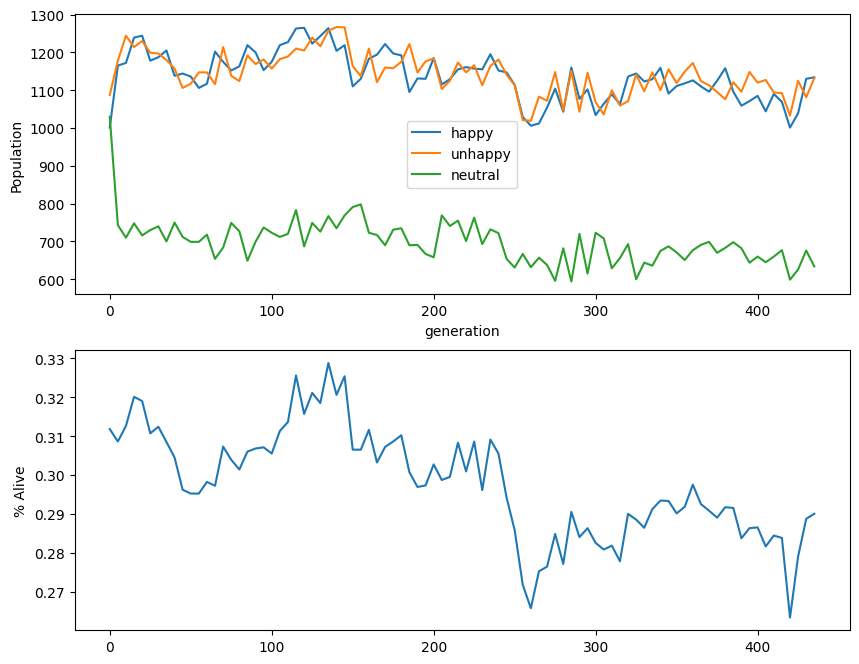

In [86]:
pg.display.init()
disp_size = (900, 900)
room_size = (100,100)
screen = pg.display.set_mode(disp_size, pg.DOUBLEBUF)
pg.display.set_caption("Social Dynamics")
sd = SocialDynamics(screen, 32, room_size, draw=True, max_gen=50_000, seed=0)
sd.birth_probs = [0.21495]*3
sd.birth_probs.insert(0, 1-sum(sd.birth_probs))
# sd.paused = True
sd.run()
pg.quit()
print(sd.generation,'generations ',sd.birth_probs)

fig, ax = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(10)
sd.popdata.plot(x='generation', y=['happy','unhappy','neutral'],kind='line', ax=ax[0])
fig.axes[0].set_ylabel("Population")
ax[1] = plt.plot(sd.popdata['generation'], sd.popdata['alive'] / (room_size[0]*room_size[1]))
fig.axes[1].set_ylabel("% Alive")
plt.show()

In [14]:
rd = results.to_dict(orient='tight')
list(rd.items())

[('index', [0]),
 ('columns', ['generations', 'popdata']),
 ('data',
  [[27675,       generation  happy  unhappy  neutral  alive  change
    0              0   1024     1044     1010   3078       0
    1              5   1191     1163      814   3168    3741
    2             10   1174     1115      765   3054    3644
    3             15   1144     1197      716   3057    3594
    4             20   1170     1220      710   3100    3588
    ...          ...    ...      ...      ...    ...     ...
    5531       27655     29       29        2     60      57
    5532       27660     26       26        8     60      57
    5533       27665     26       27        2     55      54
    5534       27670     25       24        6     55      51
    5535       27675     26       27        2     55      51
    
    [5536 rows x 6 columns]]]),
 ('index_names', [None]),
 ('column_names', [None])]

In [14]:
pg.quit()

In [6]:
results

,generations,popdata
0,48285,generation happy unhappy neutral ali...


In [466]:
len(sd.popdata)/50.0

193.72

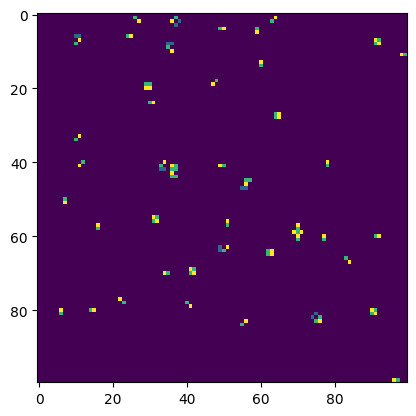

In [389]:
w,h = sd.room.shape
w-=2
h-=2

plt.imshow(sd.room[1:w+1,1:h+1])
r = sd.room[1:w+1, 1:h+1]


In [381]:

arr = np.zeros((20,20), dtype=np.int16)
arr[4:6,4:6] = 1
arr[11:14, 11:14] = 2
arr[8:10, 2:4] = 3
print(arr, arr.shape)
kernel = np.ones((2,2), np.int16)
kernel[0,0] = 3
kernel[1,0:2] = -1
kernel[0,1] = -1
print(kernel, kernel.shape)
count_arr = signal.convolve2d(arr>0, kernel, mode='same').astype(np.int16)

count_arr[count_arr[:,:] < 0] = 0
print(count_arr, count_arr.shape)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]] (20, 20)
[[ 3 -1]
 [-1 -1]] (2, 2)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 

In [58]:
ruletex = sd.ruletex.copy()
ruletex
# ruletex[(ruletex['N3-happy'] > (ruletex['N1-neutral']+ruletex['N2-unhappy']+ruletex['N0-dead'])) & (ruletex.loc[:,'N1-neutral':'N3-happy'].sum(1) <= 3)]['next_state'] = 3 # happy
ruletex['living'] = ruletex.loc[:,'N1-neutral':'N3-happy'].sum(1)
ruletex['next_state'] = 0


ruletex

,N0-dead,N1-neutral,N2-unhappy,N3-happy,current_state,living,next_state
0,0,0,0,8,0,8,0
1,0,0,1,7,0,8,0
2,0,0,2,6,0,8,0
3,0,0,3,5,0,8,0
4,0,0,4,4,0,8,0
...,...,...,...,...,...,...,...
655,6,2,0,0,3,2,0
656,7,0,0,1,3,1,0
657,7,0,1,0,3,1,0
658,7,1,0,0,3,1,0


## Conway's game of life

In [ ]:
class Life:
    def __init__(self, screen, target_fps):
        self.screen = screen
        self.target_fps = target_fps
        self.clock = pg.time.Clock()
        self.w = self.screen.get_size()[0]
        self.h = self.screen.get_size()[1]
        self.states = States(alive=1, dead=0)
        self.bgc = (0, 0, 0)
        self.colors = [0]*len(self.states.__dict__)
        self.colors[self.states.alive] = (255, 127, 255)
        self.colors[self.states.dead] = (0, 0, 0)
        # used for randomly setting cells as alive at t=0
        self.probability_of_life = 0.18
        # may need to specify seed here
        self.rand = np.random.default_rng()
        self.generation = 0
        self.n_cells_changed = 0
        self.n_cells_alive = 0
        self.setup_room()
    
    def run(self):
        running = True
        while running:
            # handle events
            for event in pg.event.get():
                if event.type == pg.QUIT:
                    running = False

            # handle game logic here
            self.new_generation()
            self.plot_life()
            
            # screen locks
            while self.screen.get_locked():
                self.screen.unlock()
            # update the screen
            pg.display.flip()
            # limit the fps
            self.clock.tick(self.target_fps)
    
    def new_generation(self):
        # create a new generation using the ruleset
        self.generation += 1
        w,h = self.w,self.h
        # an array representing the number of neighbors (including self) of each cell in the room (not counting border rows or columns)
        neighbors = self.room[1:w + 1, 1:h + 1] \
            + self.room[1:w + 1, 0:h] \
            + self.room[1:w + 1, 2:h + 2] \
            + self.room[0:w, 1:h + 1] \
            + self.room[0:w, 0:h] \
            + self.room[0:w, 2:h + 2] \
            + self.room[2:w + 2, 1:h + 1] \
            + self.room[2:w + 2, 0:h] \
            + self.room[2:w + 2, 2:h + 2]
            
        # apply rules
        #   1. if cell is alive and
        #       a. has 2 alive neigbors, it survives
        #       b. has 3 alive neighbors, it surives
        #   2. if a dead cell has 3 neighbors, it becomes alive
        #   3. otherwise cell is dead or dies
        self.room[1:w+1, 1:h+1][neighbors[:,:] == 3] = self.states.alive # applying rule 1a and rule 2
        self.room[1:w+1, 1:h+1][(neighbors[:,:] < 3) | (neighbors[:,:] > 4)] = self.states.dead # applying rule 3 and implicitly 1b (no action taken)
        
        self.update_borders()
        
        # perform life counts
        check_frequency = 30 # every n generations
        if self.generation % check_frequency == 0:
            self.n_cells_changed = (self.check_room[1:w+1, 1:h+1] != self.room[1:w+1, 1:h+1]).sum()
            self.n_cells_alive = self.room[1:w+1, 1:h+1].sum()
            self.check_room = self.room.copy()
        
    def update_borders(self):
        w,h = self.w, self.h
        # handle wrapping edges around to other sides
        ## second to bottommost row is copied into top border row
        self.room[0:1, :] = self.room[w:w+1, :] # note, this weird indexing is so that the ndarray returned has shape (1, w+2) instead of shape (w+2,)
        ## second to topmost row is copied into bottom border row
        self.room[w+1:w+2, :] = self.room[1:2, :]
        ## second to rightmost column is copied into left border column
        self.room[:, 0:1] = self.room[:, h:h+1]
        ## second to leftmost column is copied into right border column
        self.room[:, h+1:h+2] = self.room[:, 1:2]
    
    def setup_room(self):
        # init the array to be the size of the screen plus a 1 pixel border for wrapping around (toroid topology)
        w,h = self.w, self.h
        self.room = self.rand.random(size=(w+2, h+2)) + self.probability_of_life
        self.room = self.room.astype(np.uint8)
        self.update_borders()
        # used for determining amount of cells that have changed in the current generation
        self.check_room = self.room.copy()
        self.gen = 0
        self.n_cells_changed = 0
        self.n_cells_alive = self.room[1:w+1, 1:h+1].sum()
    
    def plot_life(self):
        while self.screen.get_locked():
            self.screen.unlock()
        w,h = self.w, self.h
        rgbarr = pg.surfarray.pixels2d(self.screen)
        rgbarr[:,:] = self.room[1:w+1, 1:h+1] * self.get_24bit_color(self.colors[self.states.alive])
    
    def get_24bit_color(self, color : tuple):
        if len(color) != 3:
            return 0
        # given 8 bit color in rgb, 
        # 24bit_color = 256^2 r + 256 g + b 
        return color[0] * 256 ** 2 + color[1] * 256 + color[2]

pg.display.init()
disp_size = (800, 800)
screen = pg.display.set_mode(disp_size, pg.DOUBLEBUF)
pg.display.set_caption("Conways Game of Life")
life = Life(screen, 60)
life.run()
pg.quit()

# Scratch Paper

In [3]:
rng = np.random.default_rng(seed=5)
w,h = 5,5
# room = rng.random((w+2, h+2)) + 0.3
room = np.eye(w+2, h+2)
room = room.astype(np.uint8)
print(room)
# print('shape', room.shape)
print()
# print(room[1:h+1])
room[1:w+1, 1:h+1][room[1:w+1, 1:h+1]==1] = 2
# print(room)
# print(room[0:1, :], type(room[0:1, :]), ' shape:', room[0:1, :].shape)
# print(room[0, :], type(room[0, :]), ' shape:', room[0, :].shape)
room[0:1, :] = room[w:w+1, :]
room[w+1:w+2, :] = room[1:2, :]
room[:, 0:1] = room[:, h:h+1]
room[:, h+1:h+2] = room[:, 1:2]
print(room)

room = np.array([
    [0,5,3,5,3,4,4],
    [1,2,3,4,5,6,7],
    [0,0,0,0,0,0,0],
    [1,4,4,4,9,0,3],
    [8,2,3,4,1,1,1],
    [3,5,1,5,6,3,5],
    [1,5,3,7,9,5,0]
], np.uint8)

[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]

[[2 0 0 0 0 2 0]
 [0 2 0 0 0 0 2]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [2 0 0 0 0 2 0]
 [0 2 0 0 0 0 2]]


In [5]:
choices = [0,1,2,3]
probs = [1-3*0.15, 0.15, 0.15, 0.15]
rand = np.random.default_rng()
newroom = rand.choice(a=choices,
                        size=(w+2,h+2),
                        p=probs,
                        replace=True).astype(np.uint8)
print(newroom)

[[0 1 0 1 2 3 0]
 [0 0 0 1 0 1 0]
 [0 2 0 1 0 3 0]
 [3 3 0 0 0 2 0]
 [3 1 3 0 0 0 0]
 [0 0 3 0 0 0 2]
 [3 0 0 0 0 1 0]]


In [28]:
nbmask = np.array([[1,1,1],[1,0,1],[1,1,1]], dtype=np.bool_)
def _count_neutral_neighbors(arr, i,j):
        sub_array = arr[i-1:i+2, j-1:j+2]
        return np.sum(sub_array[nbmask]==2)

def count_neighbors_val(matrix, val):
    # Define the indices of the neighboring cells
    indices = np.array([[-1, -1], [-1, 0], [-1, 1],
                        [0, -1], [0, 1],
                        [1, -1], [1, 0], [1, 1]])

    # Pad the matrix with zeros to handle boundary cells
    padded_matrix = np.pad(matrix, 1, mode='constant', constant_values=0)

    # Compute the number of neighboring cells equal to 3 using a convolution
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    neighbor_counts = (np.convolve(padded_matrix == val, kernel, mode='same') - (matrix == val))

    return neighbor_counts

# print(_count_neutral_neighbors(room, 3, 3))
# print(count_neighbors_val(room, 2))
kernel = np.ones((3, 3))
kernel[1, 1] = 0
padded_matrix = np.pad(room, 1, mode='constant', constant_values=0)
# print(padded_matrix)
print(room)

# print((room[1:w+1, 1:h+1]==2))
# (signal.convolve2d(room == 2, kernel, mode='same').astype(np.uint8)-(room==2))[1:w+1,1:h+1]


[[2 0 0 0 0 2 0]
 [0 2 0 0 0 0 2]
 [0 0 2 0 0 0 0]
 [0 0 0 2 0 0 0]
 [0 0 0 0 2 0 0]
 [2 0 0 0 0 2 0]
 [0 2 0 0 0 0 2]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [37]:

def count_neighbors_of_value(matrix, value):
    neighbor_kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    mask = (matrix==value)
    neighbor_count = signal.convolve2d(mask, neighbor_kernel, mode='same', boundary='fill')
    return neighbor_count
room = np.array([
    [0,5,3,5,3,4,4],
    [1,2,3,4,5,6,7],
    [0,0,0,0,0,0,0],
    [1,4,4,4,9,0,3],
    [8,2,3,4,1,1,1],
    [3,5,1,5,6,3,5],
    [1,5,3,7,9,5,0]
], np.uint8)

room = np.zeros_like(room)
room[0,0] = 4

print(count_neighbors_of_value(room, 4))


[[0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [57]:
neighbors = room[1:w + 1, 1:h + 1] \
            + room[1:w + 1, 0:h] \
            + room[1:w + 1, 2:h + 2] \
            + room[0:w, 1:h + 1] \
            + room[0:w, 0:h] \
            + room[0:w, 2:h + 2] \
            + room[2:w + 2, 1:h + 1] \
            + room[2:w + 2, 0:h] \
            + room[2:w + 2, 2:h + 2]
print(neighbors)

[[3 2 1 1 2]
 [2 3 2 1 1]
 [1 2 3 2 1]
 [1 1 2 3 2]
 [2 1 1 2 3]]


# Setting up the room

In [8]:
# room is 800x800 with a 1 pixel wide kill boundary
room = np.zeros(shape=(802, 802), dtype=np.byte)

In [ ]:
def updateRoom(room, ruleset):
    for rule in ruleset:
        # apply the rule to each cell in the room
        pass
    
    return new_room

# pygame

In [6]:
pg.init()
pg.display.set_caption("social dynamics cellular automata")
# create a surface on screen of size
screen = pg.display.set_mode((800, 800))
# variable that controls the main loop
running = True
# main loop
while running:
    # event handling, gets all events from the event queue
    for event in pg.event.get():
        if event.type == pg.QUIT:
            running = False
    # game logic goes here
    pg.display.update()

pg.quit()